In [102]:
# Important standard packages 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [104]:
# Importing packages used in data pre-processing
import gensim
from gensim.utils import simple_preprocess, tokenize
from gensim.parsing.preprocessing import STOPWORDS
import gensim.corpora as corpora
from nltk.stem.porter import *
from nltk.tokenize import RegexpTokenizer
import nltk
from nltk.corpus import stopwords
import string 
from tqdm import tqdm
from pprint import pprint
import time

# Preparing data
1. Loading data and dropping irrelevant columns
2. Removal of NaN values from relevant attributes
3. Create new dataframe consisting of only keywords and country ID

In [3]:
data=pd.read_csv("FAOLEX_ALL.csv")
# print(data.keys())
# print(df.info())
# print(keywords[:5])

# Create simplified version of the dataframe by discarding irrelevant columns 
to_drop = ['Record Id', 
           'Record URL', 
           'Document URL', 
           'Title',
           'Original title',
           'Available website',
           'Abstract']

data.drop(to_drop, inplace=True, axis=1)

In [4]:
# Remove NaN values in the Countries/Territory and Keywords attributes 
data_no_nan = data.dropna(subset=["Country/Territory", "Keywords"])
print(f"This results in {len(data) - len(data_no_nan)} rows being dropped")

This results in 939 rows being dropped


In [5]:
data_kw = data_no_nan[["Country/Territory","Keywords"]]
data_kw['index'] = data_kw.index
keywords = data_kw

/var/folders/sb/klhtpy1n7jd649__g8r7xj300000gn/T/ipykernel_17605/1041940241.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_kw['index'] = data_kw.index


# Data pre-processing (v2)

In [21]:
tokenizer = RegexpTokenizer(r'\w+') # create tokenizer to tokenize docs 
stop_words = stopwords.words('english') # create list of stopwords
p_stemmer = PorterStemmer() # create stemmer instance 


In [79]:
doc_set = keywords["Keywords"].tolist()
processed_kw_list = []

# loop through document list
for i in tqdm(doc_set):
    
    # clean and tokenize document string
    raw = i.lower()
    tokens = tokenizer.tokenize(raw)

    # remove stop words from tokens
    stopped_tokens = [i for i in tokens if not i in stop_words]
    
    # stem tokens
    stemmed_tokens = [p_stemmer.stem(i) for i in stopped_tokens]
    
    # add tokens to list
    processed_kw_list.append(stemmed_tokens)
    #processed_kw_list.append(stopped_tokens)
    


100%|██████████| 195498/195498 [00:28<00:00, 6779.25it/s]


# Data pre-processing (v1)
1. Create various pre-processing functions
2. Perform the pre-processing on the simplified dataframe created above
3. Stopwords removal
4. Lemmatization (yet to be done)

In [6]:
# Create function to remove punctuation from input text
def remove_punctuation(text):
    # signs = ";'-"
    signs = ";"
    #return "".join([i for i in text if i not in string.punctuation])
    
    return "".join([i for i in text if i not in signs])

'''
def remove_stop_words(text): 
    for word in text: 
        if word in stop_words: 
            text = text.replace(word, '')
    return text
'''


# Create function to do data pre-processing (excluding stop word removal and lemmatization)
def pre_process(text):
    text = remove_punctuation(text)
    # text = remove_stop_words(text)
    text = text.lower()
    processed = list(tokenize(text))
    
    return processed


In [7]:
# Performing pre-processsing 
processed_kw = keywords["Keywords"].map(pre_process)

# Convert to a list
processed_kw_list = processed_kw.values.tolist()

# Remove stop words
stop_words = stopwords.words('english')
for lists in processed_kw_list:
    for kw in lists: 
        if kw in stop_words:
            lists.remove(kw)

# Lemmatization 
# TODO figure out a way to do this 


# LDA model

In [81]:
# Mapping from word IDs to words
# https://medium.com/analytics-vidhya/topic-modeling-using-gensim-lda-in-python-48eaa2344920
id2word = corpora.Dictionary(processed_kw_list)

# Prepare Document-Term matrix
corpus = []
for doc in processed_kw_list:
    corpus.append(id2word.doc2bow(doc))

In [73]:
# Creating the LDA model
n_topics = 7
# Documentation: https://radimrehurek.com/gensim/models/ldamodel.html
'''
lda_model = gensim.models.ldamodel.LdaModel(corpus = corpus, 
                                            id2word = id2word, 
                                            num_topics=n_topics, 
                                            random_state=100, 
                                            passes = 20)
'''
lda_model = gensim.models.ldamulticore.LdaMulticore(corpus = corpus, 
                                            id2word = id2word, 
                                            num_topics=n_topics, 
                                            random_state=100, 
                                            passes = 20)


In [69]:
pprint(lda_model.print_topics())


[(0,
  '0.071*"fishing" + 0.069*"marine" + 0.061*"collection" + 0.061*"data" + '
  '0.061*"reporting" + 0.046*"management" + 0.041*"fisheries" + '
  '0.038*"conservation" + 0.036*"fishery" + 0.035*"compliance"'),
 (1,
  '0.090*"proceedings" + 0.045*"legal" + 0.045*"administrative" + '
  '0.034*"system" + 0.033*"international" + 0.033*"industry" + '
  '0.033*"business" + 0.033*"corporations" + 0.032*"production" + '
  '0.029*"building"'),
 (2,
  '0.082*"land" + 0.043*"public" + 0.043*"rights" + 0.033*"agricultural" + '
  '0.031*"indigenous" + 0.029*"use" + 0.027*"gender" + 0.024*"rural" + '
  '0.024*"social" + 0.021*"peoples"'),
 (3,
  '0.067*"management" + 0.065*"conservation" + 0.063*"protection" + '
  '0.055*"forest" + 0.048*"assessment" + 0.034*"environmental" + '
  '0.028*"ecosystem" + 0.027*"impact" + 0.027*"protected" + 0.026*"area"'),
 (4,
  '0.072*"development" + 0.064*"water" + 0.052*"sustainable" + '
  '0.042*"agricultural" + 0.042*"planning" + 0.037*"policy" + 0.035*"energy"

In [99]:
# Compute Coherence Score (the higher the better)
coherence_model_lda = gensim.models.coherencemodel.CoherenceModel(model=lda_model, texts=processed_kw_list, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

Coherence Score:  0.4307110901057344


In [82]:
# Create function to find optimal topic_num to use in LDA model
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for topic_n in tqdm(range(start, limit, step)):
        # model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=topic_n, id2word=dictionary, random_state=100, passes = 5)
        model = gensim.models.ldamulticore.LdaMulticore(corpus=corpus, num_topics=topic_n, id2word=dictionary, random_state=100, passes=5)
        model_list.append(model)
        coherencemodel = gensim.models.coherencemodel.CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [75]:
# Finding the optimal number of topics by creating multiple LDA models and computing coherence score
dictionary = id2word
corpus = corpus
texts = processed_kw_list
limit = 300
start = 10
step = 10

model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=texts, limit=limit, start=start, step=step)

  0%|          | 0/29 [00:06<?, ?it/s]


KeyboardInterrupt: 

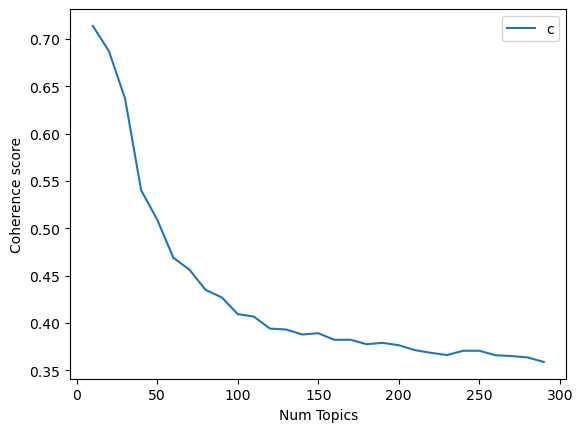

In [71]:
# Show graph
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [76]:
dictionary = id2word
corpus = corpus
texts = processed_kw_list
limit = 100
start = 70
step = 3

model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=texts, limit=limit, start=start, step=step)

100%|██████████| 10/10 [24:12<00:00, 145.22s/it]


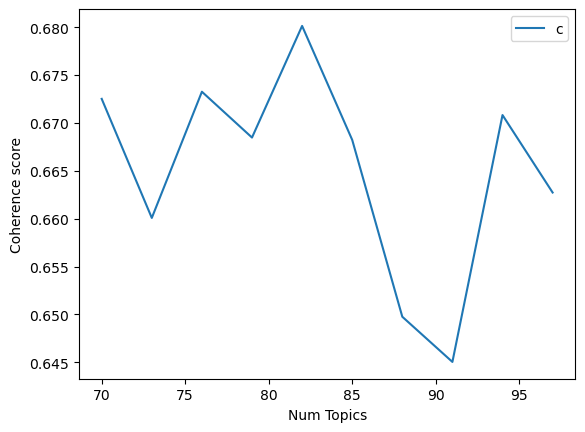

In [77]:
# Show graph
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [83]:
dictionary = id2word
corpus = corpus
texts = processed_kw_list
limit = 110 
start = 70
step = 2

models = []
coherences = []
for i in tqdm(range(3)): 
    model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=texts, limit=limit, start=start, step=step)
    models.append(model_list)
    coherences.append(coherence_values)

100%|██████████| 3/3 [5:23:24<00:00, 6468.32s/it]  


In [105]:
# Fixes mistake made in above loop where coherence appended itself. The issue above has also been fixed, so this is only applicaple one time. 
models_copy = models.copy()
coherences = []
for run in tqdm(models_copy, desc="Outer", position=0):
    coherences_run = []
    for model in tqdm(run, desc=" Inner loop", position=1, leave=False): 
        time.sleep(0.05)
        coherence_model_lda = gensim.models.coherencemodel.CoherenceModel(model=model, texts=processed_kw_list, dictionary=id2word, coherence='c_v')
        coherence_lda = coherence_model_lda.get_coherence()
        coherences_run.append(coherence_lda)
    coherences.append(coherences_run)


Outer: 100%|██████████| 3/3 [10:24<00:00, 208.07s/it]


In [107]:
# Create list of average coherence values 
avg_coherence_values = []

for i in range(len(coherence_values)): 
    total_i = coherences[0][i] + coherences[1][i] + coherences[2][i]
    avg_i = total_i / 3
    avg_coherence_values.append(avg_i)

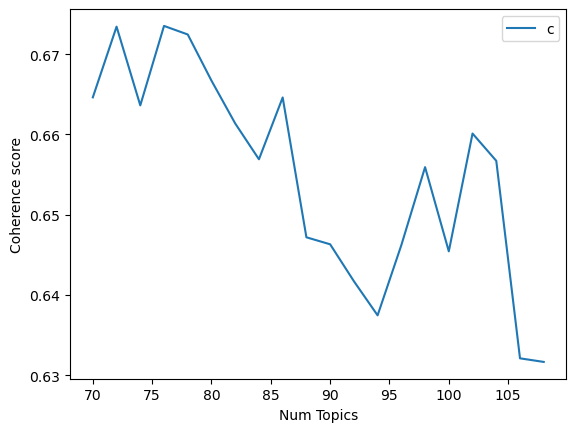

In [108]:
limit = 110 
start = 70
step = 2

x = range(start, limit, step)
plt.plot(x, avg_coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

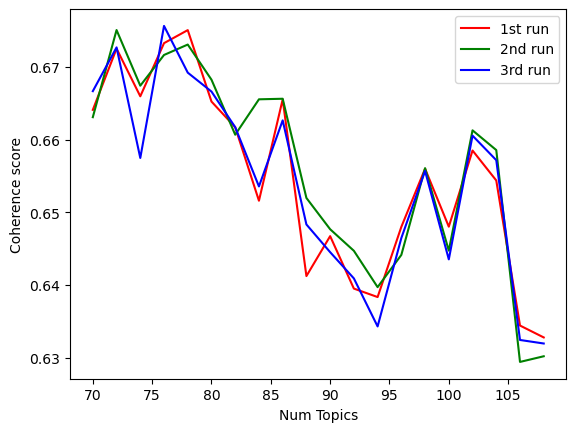

In [109]:
# Plot for each run 
limit = 110
start = 70
step = 2

x = range(start, limit, step)

# List of three lists
list1 = coherences[0]
list2 = coherences[1]
list3 = coherences[2]

# List of list names for the legend
list_names = ['1st run', '2nd run', '3rd run']

# List of colors for each list
colors = ['red', 'green', 'blue']

# Plot each list separately
for i, lst in enumerate([list1, list2, list3]):
    plt.plot(x, lst, color=colors[i])

plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(list_names, loc='best')
plt.show()

In [90]:
# Visualizing the topics using pyLDAvis
import pyLDAvis
import pyLDAvis.gensim_models

pyLDAvis.enable_notebook()
visualization = pyLDAvis.gensim_models.prepare(
    lda_model, 
    corpus,
    id2word, 
    mds = "mmds", 
    R = 30)

BrokenProcessPool: A task has failed to un-serialize. Please ensure that the arguments of the function are all picklable.

# Random texting of various functions

In [29]:
from nltk.corpus import stopwords
test = "This is a test. It contains VERY specific words such as Jonathan, Gustav and Jacob"
test = test.lower().split()
test = [word for word in test if not word in set(stopwords.words('english'))]
test1 = ' '.join(test)
print(test)
print(test1)

['test.', 'contains', 'specific', 'words', 'jonathan,', 'gustav', 'jacob']
test. contains specific words jonathan, gustav jacob
